DQN ROBUSTNESS UNDER STOCHASTICITY

In [35]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from pathlib import Path
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from dataclasses import dataclass, asdict
print("✓ Dependencies loaded")

✓ Dependencies loaded


In [24]:
SEEDS = [0, 42, 1729, 6174, 196]
FAILURE_PROBS = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
TRAINING_TIMESTEPS = 700_000
N_EVAL_EPISODES = 100

DQN_CONFIG = {
    'learning_rate': 1e-3,
    'buffer_size': 100_000,
    'learning_starts': 10_000,
    'batch_size': 64,
    'gamma': 0.99,
    'train_freq': 4,
    'gradient_steps': 1,
    'target_update_interval': 10_000,
    'exploration_fraction': 0.2,
    'exploration_initial_eps': 1.0,
    'exploration_final_eps': 0.05,
    'verbose': 0,
}

sns.set_style("whitegrid")
plt.rcParams.update({'figure.dpi': 150, 'font.size': 11})

print("✓ Configuration loaded")

✓ Configuration loaded


### ENVIRONMENT WRAPPERS

In [25]:
class StochasticLunarLanderWrapper(gym.Wrapper):
    """
    Corrected wrapper implementing:
    - Episode-level stochasticity (all randomness sampled at reset)
    - Single failure onset time
    - Severity-based failure effects
    - Valid failure tracking for metrics
    """
    
    FAMILIES = ['sensor', 'actuator', 'dynamics', 'catastrophic']
    
    def __init__(self, env, failure_prob=0.0, seed=None):
        super().__init__(env)
        self.failure_prob = failure_prob
        self.rng = np.random.RandomState(seed)
        
        # Episode-level parameters (sampled once per episode)
        self.active_family = None
        self.failure_step = None      # When failure starts (FIX #1)
        self.failure_severity = None    # How severe (0.0-1.0)
        
        # Tracking for metrics
        self.failure_occurred = False  # Track if failure was activated (FIX #2)
        self.current_step = 0
        
        # Family-specific persistent state
        self._reset_family_states()
        self.last_obs = None
    
    def _reset_family_states(self):
        """Reset all family-specific failure states"""
        # Sensor failures
        self.altimeter_bias = 0.0
        self.gyro_scale = 1.0
        self.velocity_bias = 0.0
        self.dropout_indices = []
        
        # Actuator failures
        self.thrust_multiplier = 1.0
        self.left_mult = 1.0
        self.right_mult = 1.0
        self.control_delay = 0
        self.action_buffer = []
        
        # Dynamics failures
        self.mass_loss_rate = 0.0
        self.gravity_mult = 1.0
        self.current_mass = 1.0
        self.wind_magnitude = 0.0
        
        # Catastrophic failures
        self.engine_disabled = False
        self.landing_gear_failed = False
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        
        # Reset episode state
        self._reset_family_states()
        self.current_step = 0
        self.failure_occurred = False
        self.last_obs = obs.copy()
        
        # Episode-level stochasticity: decide if failure occurs
        if self.rng.random() < self.failure_prob:
            # Sample failure parameters ONCE for entire episode
            self.active_family = self.rng.choice(self.FAMILIES)
            self.failure_severity = self.rng.uniform(0.3, 1.0)   # How severe
            
            # FIX #1: Set failure_step after picking family and severity
            self.failure_step = self.rng.randint(20, 200)
            
            self._initialize_failure_parameters()
        else:
            # No failure this episode
            self.active_family = None
            self.failure_step = None
            self.failure_severity = None
        
        info['active_family'] = self.active_family
        info['failure_step'] = self.failure_step
        info['failure_severity'] = self.failure_severity
        
        return obs, info
    
    def _initialize_failure_parameters(self):
        """
        Initialize failure parameters based on severity.
        All randomness sampled here, not during steps.
        """
        sev = self.failure_severity
        
        if self.active_family == 'sensor':
            # Severity controls magnitude of sensor errors
            self.gyro_scale = 1.0 + sev * self.rng.choice([-1.0, 1.0])
            self.velocity_bias = sev * self.rng.uniform(-2.0, 2.0)
            # Dropout: higher severity = more indices affected
            n_dropout = int(sev * 2) + 1
            self.dropout_indices = self.rng.choice([0, 1, 4], size=min(n_dropout, 3), replace=False).tolist()
        
        elif self.active_family == 'actuator':
            # Severity controls degradation amount
            mode = self.rng.choice(['thrust', 'asymmetry', 'delay'])
            if mode == 'thrust':
                # Higher severity = more thrust loss
                self.thrust_multiplier = 1.0 - sev * 0.6
            elif mode == 'asymmetry':
                # Higher severity = more asymmetry
                weak_mult = 1.0 - sev * 0.7
                if self.rng.random() < 0.5:
                    self.left_mult = weak_mult
                else:
                    self.right_mult = weak_mult
            else:  # delay
                # Higher severity = longer delay
                self.control_delay = int(sev * 5) + 1
        
        elif self.active_family == 'dynamics':
            mode = self.rng.choice(['mass_loss', 'gravity', 'wind'])
            if mode == 'mass_loss':
                # Higher severity = faster mass depletion
                self.mass_loss_rate = sev * 0.005
            elif mode == 'gravity':
                # Higher severity = larger gravity deviation
                self.gravity_mult = 1.0 + sev * self.rng.choice([-0.3, 0.3])
            else:  # wind
                # Higher severity = stronger wind
                self.wind_magnitude = sev * 3.0
        
        elif self.active_family == 'catastrophic':
            mode = self.rng.choice(['engine_cutoff', 'landing_gear'])
            if mode == 'engine_cutoff':
                self.engine_disabled = True
            else:
                self.landing_gear_failed = True
    
    def observation(self, obs):
        """Apply sensor failures if active and started"""
        if self.active_family != 'sensor':
            return obs
        
        # FIX #4: Do not apply sensor failures before failure_step
        failure_active = (
            self.active_family is not None and
            self.current_step >= self.failure_step
        )
        
        if not failure_active:
            self.last_obs = obs.copy()
            return obs
        
        obs = obs.copy()
        
        # Persistent biases (scaled by severity, sampled at reset)
        obs[1] += self.altimeter_bias
        obs[4] *= self.gyro_scale
        obs[2] += self.velocity_bias
        
        # Persistent dropout
        for idx in self.dropout_indices:
            if self.last_obs is not None:
                obs[idx] = self.last_obs[idx]
        
        # Accumulate altimeter drift over time
        self.altimeter_bias += 0.01 * self.failure_severity
        
        self.last_obs = obs.copy()
        return obs
    
    def step(self, action):
        self.current_step += 1
        
        # FIX #2: Failures should only activate after failure_step
        failure_active = (
            self.active_family is not None and
            self.current_step >= self.failure_step
        )
        
        # Set the flag exactly once
        if failure_active and not self.failure_occurred:
            self.failure_occurred = True
        
        # FIX #3: Wrap every failure application with failure_active check
        
        # Apply actuator failures if active and started
        if failure_active and self.active_family == 'actuator':
            action = self._apply_actuator_failures(action)
        
        # Apply catastrophic failures if active and started
        if failure_active and self.active_family == 'catastrophic':
            action = self._apply_catastrophic_failures(action)
        
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Apply observation failures
        obs = self.observation(obs)
        
        # Apply dynamics failures if active and started
        if failure_active and self.active_family == 'dynamics':
            self._apply_dynamics_failures(action)
        
        # Apply actuator physics modifications
        if failure_active and self.active_family == 'actuator':
            self._apply_actuator_physics()
        
        # Handle landing gear failure
        if failure_active and self.active_family == 'catastrophic':
            if self.landing_gear_failed and terminated and reward > 0:
                reward = -100
                info['landing_gear_crash'] = True
        
        return obs, reward, terminated, truncated, info
    
    def _apply_actuator_failures(self, action):
        """Apply actuator failures (persistent effects)"""
        # Control delay
        if self.control_delay > 0:
            self.action_buffer.append(action)
            if len(self.action_buffer) > self.control_delay:
                action = self.action_buffer.pop(0)
            else:
                action = 0
        
        # FIX #3: Make actuator lag severity-dependent
        if self.rng.random() < (0.2 + 0.6 * self.failure_severity):
            # introduce lag
            self.action_buffer.append(action)
            action = 0
        
        return action
    
    def _apply_actuator_physics(self):
        """Apply persistent actuator degradation"""
        try:
            lander = self.env.unwrapped.lander
            if lander is None:
                return
            
            # Thrust degradation
            if self.thrust_multiplier < 1.0:
                vel = lander.linearVelocity
                if vel.y > 0:
                    lander.linearVelocity = (
                        vel.x,
                        vel.y * (1.0 - (1.0 - self.thrust_multiplier) * 0.2)
                    )
            
            # Thruster asymmetry
            if self.left_mult < 1.0 or self.right_mult < 1.0:
                ang_vel = lander.angularVelocity
                if self.left_mult < 1.0 and ang_vel > 0:
                    lander.angularVelocity = ang_vel * self.left_mult
                elif self.right_mult < 1.0 and ang_vel < 0:
                    lander.angularVelocity = ang_vel * self.right_mult
        except:
            pass
    
    def _apply_dynamics_failures(self, action):
        """Apply persistent dynamics modifications"""
        try:
            lander = self.env.unwrapped.lander
            if lander is None:
                return
            
            # Mass depletion (persistent loss)
            if action == 2:
                self.current_mass -= 0.001
            self.current_mass -= self.mass_loss_rate
            self.current_mass = max(0.5, self.current_mass)
            
            # Gravity variation (persistent)
            if self.gravity_mult != 1.0:
                vel = lander.linearVelocity
                correction = (self.gravity_mult - 1.0) * 0.1
                lander.linearVelocity = (vel.x, vel.y - correction)
            
            # Wind (persistent direction, sampled at reset)
            if self.wind_magnitude > 0:
                vel = lander.linearVelocity
                lander.linearVelocity = (vel.x + self.wind_magnitude * 0.05, vel.y)
        except:
            pass
    
    def _apply_catastrophic_failures(self, action):
        """Apply catastrophic failures"""
        if self.engine_disabled and action == 2:
            action = 0
        return action


def make_stochastic_lunar_lander(failure_prob, seed=None):
    """Create single environment instance with proper seeding"""
    env = gym.make('LunarLander-v2')
    env = StochasticLunarLanderWrapper(env, failure_prob, seed)
    
    if seed is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
    
    return env

print("✓ Environment wrappers loaded")

✓ Environment wrappers loaded


### Training

In [26]:
class TrainingProgressCallback(BaseCallback):
    def __init__(self, check_freq=10000, verbose=0):
        super().__init__(verbose)
        self.check_freq = check_freq
    
    def _on_step(self):
        return True


def train_dqn_agent(failure_prob, seed, save_dir, verbose=1):
    """Train on SINGLE environment (no vectorization)"""
    if verbose:
        print(f"\nTraining DQN | p={failure_prob:.2f} | seed={seed}")
    
    env = Monitor(make_stochastic_lunar_lander(failure_prob, seed))
    model = DQN('MlpPolicy', env, seed=seed, **DQN_CONFIG)
    
    callback = TrainingProgressCallback(10000, verbose)
    model.learn(TRAINING_TIMESTEPS, callback=callback, progress_bar=(verbose > 0))
    
    save_dir.mkdir(parents=True, exist_ok=True)
    model_path = save_dir / f"dqn_p{int(failure_prob*100):02d}_seed{seed}.zip"
    model.save(str(model_path))
    
    if verbose:
        print(f"✓ Saved: {model_path}")
    
    env.close()
    return model


def train_experiment1(output_dir=Path("models/exp1"), verbose=1):
    print("\n" + "="*70)
    print("EXPERIMENT 1: Training 30 agents (6 levels × 5 seeds)")
    print("="*70)
    
    models = {}
    for p in FAILURE_PROBS:
        for seed in SEEDS:
            models[(p, seed)] = train_dqn_agent(p, seed, output_dir, verbose)
    
    print("\n✓ Experiment 1 training complete")
    return models


def train_experiment2(output_dir=Path("models/exp2"), verbose=1):
    print("\n" + "="*70)
    print("EXPERIMENT 2: Training 5 agents (p=0.0 only)")
    print("="*70)
    
    models = {}
    for seed in SEEDS:
        models[(0.0, seed)] = train_dqn_agent(0.0, seed, output_dir, verbose)
    
    print("\n✓ Experiment 2 training complete")
    return models


def load_all_models_exp1(model_dir=Path("models/exp1")):
    models = {}
    for p in FAILURE_PROBS:
        for seed in SEEDS:
            path = model_dir / f"dqn_p{int(p*100):02d}_seed{seed}.zip"
            if path.exists():
                models[(p, seed)] = DQN.load(str(path))
    print(f"✓ Loaded {len(models)}/30 models")
    return models


def load_all_models_exp2(model_dir=Path("models/exp2")):
    models = {}
    for seed in SEEDS:
        path = model_dir / f"dqn_p00_seed{seed}.zip"
        if path.exists():
            models[(0.0, seed)] = DQN.load(str(path))
    print(f"✓ Loaded {len(models)}/5 models")
    return models

print("✓ Training module loaded")

✓ Training module loaded


### Evaluation

Separate metrics for each experiment

In [28]:
@dataclass
class Exp1EpisodeMetrics:
    """Experiment 1 metrics only"""
    episode_id: int
    seed: int
    failure_prob: float
    total_return: float
    episode_length: int
    success: bool
    crash: bool


@dataclass
class Exp2EpisodeMetrics:
    """Experiment 2 metrics (includes failure tracking)"""
    episode_id: int
    seed: int
    failure_prob: float
    total_return: float
    episode_length: int
    success: bool
    crash: bool
    failure_occurred: bool
    time_to_failure: int
    pre_fault_return: float
    post_fault_return: float


@dataclass
class Exp1AggregatedMetrics:
    """Experiment 1 aggregated metrics"""
    failure_prob: float
    seed: int
    n_episodes: int
    mean_return: float
    std_return: float
    success_rate: float
    crash_rate: float


@dataclass
class Exp2AggregatedMetrics:
    """Experiment 2 aggregated metrics"""
    failure_prob: float
    seed: int
    n_episodes: int
    mean_return: float
    std_return: float
    success_rate: float
    crash_rate: float
    mean_time_to_failure: float
    mean_pre_fault_return: float
    mean_post_fault_return: float


def evaluate_single_episode_exp1(model, env, ep_id, seed, failure_prob):
    """Experiment 1 evaluation (no failure tracking)"""
    obs, info = env.reset()
    
    ret, length = 0.0, 0
    done = False
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        ret += reward
        length += 1
        done = terminated or truncated
    
    metrics = Exp1EpisodeMetrics(
        episode_id=ep_id,
        seed=seed,
        failure_prob=failure_prob,
        total_return=ret,
        episode_length=length,
        success=(ret >= 200),
        crash=(ret < -100)
    )
    
    return metrics


def aggregate_metrics_exp1(metrics_list):
    """Experiment 1 aggregation"""
    returns = [m.total_return for m in metrics_list]
    successes = [m.success for m in metrics_list]
    crashes = [m.crash for m in metrics_list]
    
    return Exp1AggregatedMetrics(
        failure_prob=metrics_list[0].failure_prob,
        seed=metrics_list[0].seed,
        n_episodes=len(metrics_list),
        mean_return=np.mean(returns),
        std_return=np.std(returns),
        success_rate=np.mean(successes),
        crash_rate=np.mean(crashes)
    )


def evaluate_agent_exp1(model, failure_prob, seed, n_episodes=100):
    """Experiment 1 evaluation"""
    env = make_stochastic_lunar_lander(failure_prob, seed)
    
    metrics_list = []
    for ep in range(n_episodes):
        metrics = evaluate_single_episode_exp1(model, env, ep, seed, failure_prob)
        metrics_list.append(metrics)
    
    env.close()
    return metrics_list

print("✓ Metrics and evaluation helpers loaded")

✓ Metrics and evaluation helpers loaded


In [29]:
def evaluate_single_episode_exp2(model, env, ep_id, seed, failure_prob, record=False):
    """Experiment 2 evaluation with valid failure tracking"""
    obs, info = env.reset()
    
    ret, length = 0.0, 0
    pre_ret, post_ret = 0.0, 0.0
    frames = [] if record else None
    done = False
    
    # Extract failure info from reset
    failure_will_occur = (env.failure_step is not None)
    failure_onset = env.failure_step if failure_will_occur else float('inf')
    
    while not done:
        if record:
            frame = env.render()
            if frame is not None:
                frames.append(frame)
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        ret += reward
        length += 1
        done = terminated or truncated
        
        # Accumulate pre/post fault returns based on onset step
        if length <= failure_onset:
            pre_ret += reward
        else:
            post_ret += reward
    
    # Time to failure = onset step (or episode length if no failure)
    time_to_failure = int(failure_onset) if failure_will_occur else length
    
    # FIX #6: Only return frames if failure actually occurred
    if record and not failure_will_occur:
        frames = None
    
    metrics = Exp2EpisodeMetrics(
        episode_id=ep_id,
        seed=seed,
        failure_prob=failure_prob,
        total_return=ret,
        episode_length=length,
        success=(ret >= 200),
        crash=(ret < -100),
        failure_occurred=failure_will_occur,
        time_to_failure=time_to_failure,
        pre_fault_return=pre_ret,
        post_fault_return=post_ret
    )
    
    return metrics, frames


def evaluate_agent_exp2(model, failure_prob, seed, n_episodes=100, record_last=0):
    """Experiment 2 evaluation with failure tracking"""
    env = make_stochastic_lunar_lander(failure_prob, seed)
    
    if record_last > 0:
        env = gym.make('LunarLander-v2', render_mode='rgb_array')
        env = StochasticLunarLanderWrapper(env, failure_prob, seed)
        env.reset(seed=seed)
    
    metrics_list = []
    all_frames = []
    
    for ep in range(n_episodes):
        should_record = (ep >= n_episodes - record_last) and record_last > 0
        metrics, frames = evaluate_single_episode_exp2(
            model, env, ep, seed, failure_prob, should_record
        )
        metrics_list.append(metrics)
        # FIX #6: Only collect frames from episodes where failure occurred
        if frames:
            all_frames.extend(frames)
    
    env.close()
    return metrics_list, (all_frames if all_frames else None)


def aggregate_metrics_exp2(metrics_list):
    """Experiment 2 aggregation (includes failure metrics)"""
    returns = [m.total_return for m in metrics_list]
    successes = [m.success for m in metrics_list]
    crashes = [m.crash for m in metrics_list]
    ttf = [m.time_to_failure for m in metrics_list]
    pre_rets = [m.pre_fault_return for m in metrics_list]
    post_rets = [m.post_fault_return for m in metrics_list]
    
    return Exp2AggregatedMetrics(
        failure_prob=metrics_list[0].failure_prob,
        seed=metrics_list[0].seed,
        n_episodes=len(metrics_list),
        mean_return=np.mean(returns),
        std_return=np.std(returns),
        success_rate=np.mean(successes),
        crash_rate=np.mean(crashes),
        mean_time_to_failure=np.mean(ttf),
        mean_pre_fault_return=np.mean(pre_rets),
        mean_post_fault_return=np.mean(post_rets)
    )


def evaluate_experiment1(models, n_episodes=100, output_dir=Path("results/exp1")):
    """Experiment 1 evaluation pipeline"""
    print("\n" + "="*70)
    print("EXPERIMENT 1: Cross-evaluation")
    print("="*70)
    
    results = []
    for (train_p, train_seed), model in models.items():
        print(f"\nModel trained at p={train_p:.2f}, seed={train_seed}")
        for test_p in FAILURE_PROBS:
            print(f"  Testing at p={test_p:.2f}...", end=" ")
            metrics_list = evaluate_agent_exp1(model, test_p, train_seed, n_episodes)
            agg = aggregate_metrics_exp1(metrics_list)
            
            result = {
                'train_p': train_p,
                'test_p': test_p,
                'seed': train_seed,
                **asdict(agg)
            }
            results.append(result)
            print(f"✓ (return={agg.mean_return:.1f})")
    
    df = pd.DataFrame(results)
    output_dir.mkdir(parents=True, exist_ok=True)
    csv_path = output_dir / "exp1_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Saved: {csv_path}")
    return df


def evaluate_experiment2(models, n_episodes=100, record_gifs=True, output_dir=Path("results/exp2")):
    """Experiment 2 evaluation pipeline with failure tracking"""
    print("\n" + "="*70)
    print("EXPERIMENT 2: Zero-shot evaluation")
    print("="*70)
    
    results = []
    for (_, seed), model in models.items():
        print(f"\nModel seed={seed}")
        for test_p in FAILURE_PROBS:
            print(f"  Testing at p={test_p:.2f}...", end=" ")
            record_n = 10 if record_gifs else 0
            metrics_list, frames = evaluate_agent_exp2(
                model, test_p, seed, n_episodes, record_n
            )
            agg = aggregate_metrics_exp2(metrics_list)
            
            result = {'train_p': 0.0, 'test_p': test_p, 'seed': seed, **asdict(agg)}
            results.append(result)
            
            # FIX #6: Save GIF at 4x speed (fps=25) only if failure episodes were recorded
            if frames:
                gif_dir = output_dir / "gifs"
                gif_dir.mkdir(parents=True, exist_ok=True)
                gif_path = gif_dir / f"exp2_p{int(test_p*100):02d}_seed{seed}.gif"
                imageio.mimsave(str(gif_path), frames, fps=25, loop=0)
                print(f"✓ GIF saved (4× speed)", end=" ")
            
            print(f"(return={agg.mean_return:.1f})")
    
    df = pd.DataFrame(results)
    output_dir.mkdir(parents=True, exist_ok=True)
    csv_path = output_dir / "exp2_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Saved: {csv_path}")
    return df

print("✓ Evaluation module loaded")

✓ Evaluation module loaded


### Visualization

In [40]:
def plot_exp1_heatmap(df, metric, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    pivot = df.groupby(['train_p', 'test_p'])[metric].mean().unstack()
    if 'rate' in metric:
        pivot *= 100
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', center=50 if 'rate' in metric else 150,
                ax=ax, linewidths=1, cbar_kws={'label': metric.replace('_', ' ').title()})
    
    ax.set_xlabel('Test Failure Probability')
    ax.set_ylabel('Training Failure Probability')
    ax.set_title(f'Experiment 1: {metric.replace("_", " ").title()}')
    ax.set_xticklabels([f'{int(p*100)}%' for p in pivot.columns])
    ax.set_yticklabels([f'{int(p*100)}%' for p in pivot.index], rotation=0)
    
    plt.tight_layout()
    plt.savefig(output_dir / f'exp1_{metric}.png', dpi=300, bbox_inches='tight')
    plt.close()


def plot_exp1_robustness_curves(df, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for train_p in sorted(df['train_p'].unique()):
        subset = df[df['train_p'] == train_p]
        grouped = subset.groupby('test_p')['success_rate'].agg(['mean', 'sem'])
        
        test_ps = [p * 100 for p in grouped.index]
        means = grouped['mean'] * 100
        sems = grouped['sem'] * 100
        
        ax.plot(test_ps, means, marker='o', linewidth=2, markersize=8, 
                label=f'Train p={int(train_p*100)}%')
        ax.fill_between(test_ps, means - 1.96*sems, means + 1.96*sems, alpha=0.2)
    
    ax.axhline(50, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50% Threshold')
    ax.set_xlabel('Test Failure Probability (%)')
    ax.set_ylabel('Success Rate (%)')
    ax.set_title('Experiment 1: Robustness Curves')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-5, 105)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'exp1_robustness_curves.png', dpi=300, bbox_inches='tight')
    plt.close()


def plot_exp2_performance(df, metric, output_dir):
    output_dir.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    grouped = df.groupby('test_p')[metric].agg(['mean', 'sem'])
    test_ps = [p * 100 for p in grouped.index]
    means = grouped['mean']
    sems = grouped['sem']
    
    if 'rate' in metric:
        means *= 100
        sems *= 100
    
    ax.plot(test_ps, means, marker='o', linewidth=3, markersize=10, color='steelblue')
    ax.fill_between(test_ps, means - 1.96*sems, means + 1.96*sems, alpha=0.3)
    
    if 'success_rate' in metric:
        ax.axhline(50, color='red', linestyle='--', linewidth=2, label='50% Threshold')
    
    ax.set_xlabel('Test Failure Probability (%)')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'Experiment 2: {metric.replace("_", " ").title()}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / f'exp2_{metric}.png', dpi=300, bbox_inches='tight')
    plt.close()


def create_all_exp1_plots(df, output_dir=Path("results/exp1/plots")):
    print("\nGenerating Experiment 1 plots...")
    plot_exp1_heatmap(df, 'success_rate', output_dir)
    plot_exp1_heatmap(df, 'mean_return', output_dir)
    plot_exp1_heatmap(df, 'crash_rate', output_dir)
    plot_exp1_robustness_curves(df, output_dir)
    print("✓ All Experiment 1 plots generated")


def create_all_exp2_plots(df, output_dir=Path("results/exp2/plots")):
    print("\nGenerating Experiment 2 plots...")
    plot_exp2_performance(df, 'success_rate', output_dir)
    plot_exp2_performance(df, 'crash_rate', output_dir)
    plot_exp2_performance(df, 'mean_time_to_failure', output_dir)
    plot_exp2_performance(df, 'mean_pre_fault_return', output_dir)
    plot_exp2_performance(df, 'mean_post_fault_return', output_dir)
    print("✓ All Experiment 2 plots generated")

print("✓ Visualization module loaded")

✓ Visualization module loaded


### Analysis

In [31]:
def analyze_exp1(df):
    print("\n" + "="*70)
    print("EXPERIMENT 1: Analysis")
    print("="*70)
    
    print("\nBest training probability for each test level:")
    for test_p in FAILURE_PROBS:
        best_train = df[df['test_p'] == test_p].groupby('train_p')['success_rate'].mean().idxmax()
        best_rate = df[(df['test_p'] == test_p) & (df['train_p'] == best_train)]['success_rate'].mean()
        print(f"  Test p={test_p:.2f}: Best train p={best_train:.2f} (success={best_rate*100:.1f}%)")
    
    on_dist = df[df['train_p'] == df['test_p']]['success_rate'].mean()
    off_dist = df[df['train_p'] != df['test_p']]['success_rate'].mean()
    print(f"\nGeneralization gap:")
    print(f"  On-distribution:  {on_dist*100:.1f}%")
    print(f"  Off-distribution: {off_dist*100:.1f}%")
    print(f"  Gap: {(on_dist - off_dist)*100:.1f} pp")


def analyze_exp2(df):
    print("\n" + "="*70)
    print("EXPERIMENT 2: Analysis")
    print("="*70)
    
    grouped = df.groupby('test_p')['success_rate'].mean()
    critical_p = None
    for p, rate in grouped.items():
        if rate < 0.5:
            critical_p = p
            break
    
    if critical_p:
        print(f"\nCritical failure threshold: p={critical_p*100:.0f}%")
    else:
        print("\nNo critical failure threshold (robust up to 25%)")
    
    p0 = df[df['test_p'] == 0.0]['success_rate'].mean()
    p25 = df[df['test_p'] == 0.25]['success_rate'].mean()
    print(f"\nPerformance degradation:")
    print(f"  p=0%:  {p0*100:.1f}%")
    print(f"  p=25%: {p25*100:.1f}%")
    print(f"  Drop:  {(p0 - p25)*100:.1f} pp")
    
    print(f"\nTime-to-failure analysis:")
    for p in FAILURE_PROBS:
        ttf = df[df['test_p'] == p]['mean_time_to_failure'].mean()
        print(f"  p={p:.2f}: {ttf:.1f} steps")


def compare_experiments(df1, df2):
    print("\n" + "="*70)
    print("COMPARATIVE ANALYSIS")
    print("="*70)
    
    print("\nZero-shot vs Matched training:")
    for test_p in FAILURE_PROBS:
        exp2_rate = df2[df2['test_p'] == test_p]['success_rate'].mean()
        exp1_rate = df1[(df1['train_p'] == test_p) & (df1['test_p'] == test_p)]['success_rate'].mean()
        improvement = (exp1_rate - exp2_rate) * 100
        print(f"  p={test_p:.2f}: Zero-shot={exp2_rate*100:5.1f}%, "
              f"Matched={exp1_rate*100:5.1f}%, Δ={improvement:+5.1f}pp")

print("✓ Analysis module loaded")


✓ Analysis module loaded


### Main Execution

In [36]:
def run_complete_pipeline():
    """Run complete research pipeline"""
    
    RUN_TRAINING_EXP1 = True
    RUN_TRAINING_EXP2 = True
    RUN_EVALUATION_EXP1 = True
    RUN_EVALUATION_EXP2 = True
    GENERATE_PLOTS = True
    RUN_ANALYSIS = True
    
    df_exp1 = None
    df_exp2 = None
    
    if RUN_TRAINING_EXP1:
        models_exp1 = train_experiment1(Path("models/exp1"), verbose=1)
    
    if RUN_EVALUATION_EXP1:
        models_exp1 = load_all_models_exp1(Path("models/exp1"))
        if len(models_exp1) > 0:
            df_exp1 = evaluate_experiment1(models_exp1, N_EVAL_EPISODES, Path("results/exp1"))
            if GENERATE_PLOTS:
                create_all_exp1_plots(df_exp1, Path("results/exp1/plots"))
            if RUN_ANALYSIS:
                analyze_exp1(df_exp1)
        else:
            print("\n" + "="*70)
            print("No Experiment 1 models found. Train models first or set RUN_TRAINING_EXP1=True")
            print("="*70)
    
    if RUN_TRAINING_EXP2:
        models_exp2 = train_experiment2(Path("models/exp2"), verbose=1)
    
    if RUN_EVALUATION_EXP2:
        models_exp2 = load_all_models_exp2(Path("models/exp2"))
        if len(models_exp2) > 0:
            df_exp2 = evaluate_experiment2(models_exp2, N_EVAL_EPISODES, 
                                           record_gifs=True, output_dir=Path("results/exp2"))
            if GENERATE_PLOTS:
                create_all_exp2_plots(df_exp2, Path("results/exp2/plots"))
            if RUN_ANALYSIS:
                analyze_exp2(df_exp2)
        else:
            print("\n" + "="*70)
            print("No Experiment 2 models found. Train models first or set RUN_TRAINING_EXP2=True")
            print("="*70)
    
    if RUN_ANALYSIS and df_exp1 is not None and df_exp2 is not None:
        compare_experiments(df_exp1, df_exp2)
    
    print("\n" + "="*70)
    print("✓ PIPELINE COMPLETE")
    print("="*70)


✓ ALL MODULES LOADED - CORRECTIONS APPLIED

EXPERIMENT 1: Training 30 agents (6 levels × 5 seeds)

Training DQN | p=0.00 | seed=0


Output()

Output()

✓ Saved: models\exp1\dqn_p00_seed0.zip

Training DQN | p=0.00 | seed=42


Output()

Output()

✓ Saved: models\exp1\dqn_p00_seed1729.zip

Training DQN | p=0.00 | seed=6174


Output()

Output()

✓ Saved: models\exp1\dqn_p00_seed196.zip

Training DQN | p=0.05 | seed=0


Output()

✓ Saved: models\exp1\dqn_p05_seed0.zip

Training DQN | p=0.05 | seed=42


Output()

✓ Saved: models\exp1\dqn_p05_seed42.zip

Training DQN | p=0.05 | seed=1729


Output()

✓ Saved: models\exp1\dqn_p05_seed1729.zip

Training DQN | p=0.05 | seed=6174


Output()

✓ Saved: models\exp1\dqn_p05_seed6174.zip

Training DQN | p=0.05 | seed=196


Output()

✓ Saved: models\exp1\dqn_p05_seed196.zip

Training DQN | p=0.10 | seed=0


Output()

✓ Saved: models\exp1\dqn_p10_seed0.zip

Training DQN | p=0.10 | seed=42


Output()

✓ Saved: models\exp1\dqn_p10_seed42.zip

Training DQN | p=0.10 | seed=1729


Output()

✓ Saved: models\exp1\dqn_p10_seed1729.zip

Training DQN | p=0.10 | seed=6174


Output()

✓ Saved: models\exp1\dqn_p10_seed6174.zip

Training DQN | p=0.10 | seed=196


Output()

✓ Saved: models\exp1\dqn_p10_seed196.zip

Training DQN | p=0.15 | seed=0


Output()

✓ Saved: models\exp1\dqn_p15_seed0.zip

Training DQN | p=0.15 | seed=42


Output()

✓ Saved: models\exp1\dqn_p15_seed42.zip

Training DQN | p=0.15 | seed=1729


Output()

✓ Saved: models\exp1\dqn_p15_seed1729.zip

Training DQN | p=0.15 | seed=6174


Output()

✓ Saved: models\exp1\dqn_p15_seed6174.zip

Training DQN | p=0.15 | seed=196


Output()

✓ Saved: models\exp1\dqn_p15_seed196.zip

Training DQN | p=0.20 | seed=0


Output()

✓ Saved: models\exp1\dqn_p20_seed0.zip

Training DQN | p=0.20 | seed=42


Output()

✓ Saved: models\exp1\dqn_p20_seed42.zip

Training DQN | p=0.20 | seed=1729


Output()

✓ Saved: models\exp1\dqn_p20_seed1729.zip

Training DQN | p=0.20 | seed=6174


Output()

✓ Saved: models\exp1\dqn_p20_seed6174.zip

Training DQN | p=0.20 | seed=196


Output()

✓ Saved: models\exp1\dqn_p20_seed196.zip

Training DQN | p=0.25 | seed=0


Output()

✓ Saved: models\exp1\dqn_p25_seed0.zip

Training DQN | p=0.25 | seed=42


Output()

Output()

✓ Saved: models\exp1\dqn_p25_seed1729.zip

Training DQN | p=0.25 | seed=6174


Output()

✓ Saved: models\exp1\dqn_p25_seed6174.zip

Training DQN | p=0.25 | seed=196


✓ Saved: models\exp1\dqn_p25_seed196.zip

✓ Experiment 1 training complete
✓ Loaded 30/30 models

EXPERIMENT 1: Cross-evaluation

Model trained at p=0.00, seed=0
  Testing at p=0.00... ✓ (return=151.5)
  Testing at p=0.05... ✓ (return=132.5)
  Testing at p=0.10... ✓ (return=115.1)
  Testing at p=0.15... ✓ (return=128.7)
  Testing at p=0.20... ✓ (return=112.6)
  Testing at p=0.25... ✓ (return=116.5)

Model trained at p=0.00, seed=42
  Testing at p=0.00... ✓ (return=205.7)
  Testing at p=0.05... ✓ (return=209.0)
  Testing at p=0.10... ✓ (return=177.0)
  Testing at p=0.15... ✓ (return=191.9)
  Testing at p=0.20... ✓ (return=181.4)
  Testing at p=0.25... ✓ (return=185.1)

Model trained at p=0.00, seed=1729
  Testing at p=0.00... ✓ (return=143.3)
  Testing at p=0.05... ✓ (return=136.0)
  Testing at p=0.10... ✓ (return=102.1)
  Testing at p=0.15... ✓ (return=105.4)
  Testing at p=0.20... ✓ (return=104.1)
  Testing at p=0.25... ✓ (return=93.3)

Model trained at p=0.00, seed=6174
  Testing at 

Output()

✓ All Experiment 1 plots generated

EXPERIMENT 1: Analysis

Best training probability for each test level:
  Test p=0.00: Best train p=0.00 (success=51.0%)
  Test p=0.05: Best train p=0.00 (success=49.2%)
  Test p=0.10: Best train p=0.00 (success=48.8%)
  Test p=0.15: Best train p=0.00 (success=48.2%)
  Test p=0.20: Best train p=0.00 (success=50.0%)
  Test p=0.25: Best train p=0.00 (success=44.4%)

Generalization gap:
  On-distribution:  29.4%
  Off-distribution: 29.0%
  Gap: 0.4 pp

EXPERIMENT 2: Training 5 agents (p=0.0 only)

Training DQN | p=0.00 | seed=0


Output()

✓ Saved: models\exp2\dqn_p00_seed0.zip

Training DQN | p=0.00 | seed=42


Output()

✓ Saved: models\exp2\dqn_p00_seed42.zip

Training DQN | p=0.00 | seed=1729


Output()

✓ Saved: models\exp2\dqn_p00_seed1729.zip

Training DQN | p=0.00 | seed=6174


Output()

✓ Saved: models\exp2\dqn_p00_seed6174.zip

Training DQN | p=0.00 | seed=196


✓ Saved: models\exp2\dqn_p00_seed196.zip

✓ Experiment 2 training complete
✓ Loaded 5/5 models

EXPERIMENT 2: Zero-shot evaluation

Model seed=0
  Testing at p=0.00... (return=151.5)
  Testing at p=0.05... (return=132.5)
  Testing at p=0.10... (return=115.1)
  Testing at p=0.15... (return=128.7)
  Testing at p=0.20... ✓ GIF saved (4× speed) (return=112.6)
  Testing at p=0.25... ✓ GIF saved (4× speed) (return=116.5)

Model seed=42
  Testing at p=0.00... (return=205.7)
  Testing at p=0.05... (return=209.0)
  Testing at p=0.10... (return=177.0)
  Testing at p=0.15... ✓ GIF saved (4× speed) (return=191.9)
  Testing at p=0.20... ✓ GIF saved (4× speed) (return=181.4)
  Testing at p=0.25... ✓ GIF saved (4× speed) (return=185.1)

Model seed=1729
  Testing at p=0.00... (return=143.3)
  Testing at p=0.05... ✓ GIF saved (4× speed) (return=136.0)
  Testing at p=0.10... (return=102.1)
  Testing at p=0.15... (return=105.4)
  Testing at p=0.20... ✓ GIF saved (4× speed) (return=104.1)
  Testing at p=0

FileNotFoundError: [Errno 2] No such file or directory: 'results\\exp2\\plots\\exp2_success_rate.png'

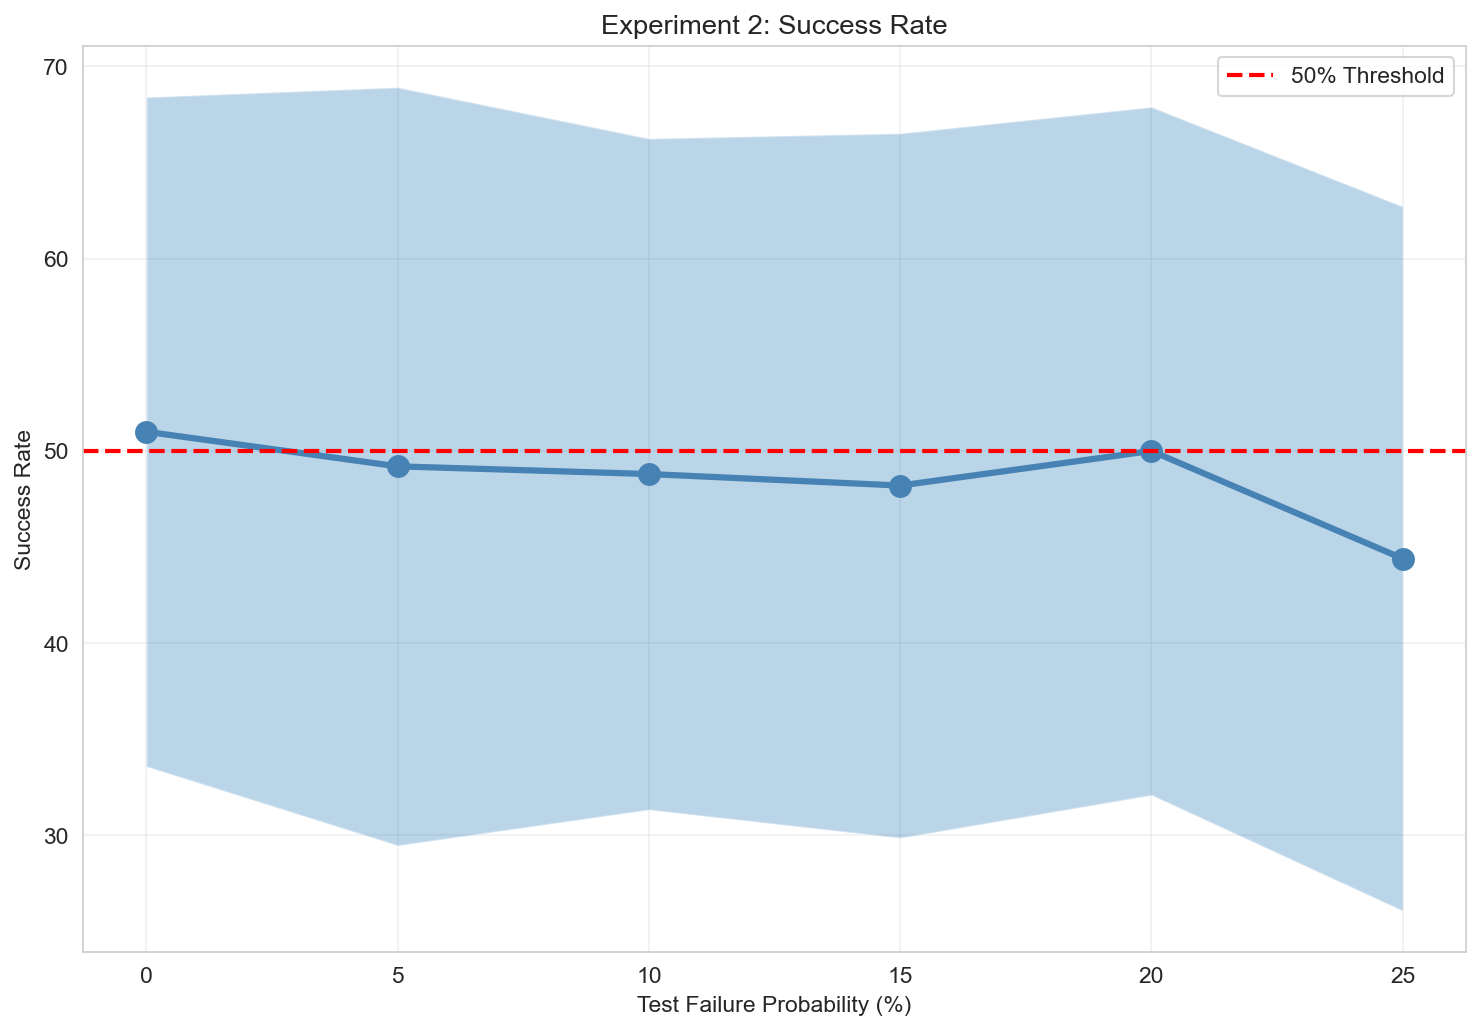

In [37]:
# Jupyter helpers
def jupyter_train_exp1():
    return train_experiment1(Path("models/exp1"), verbose=1)

def jupyter_train_exp2():
    return train_experiment2(Path("models/exp2"), verbose=1)

def jupyter_evaluate_exp1():
    models = load_all_models_exp1(Path("models/exp1"))
    df = evaluate_experiment1(models, N_EVAL_EPISODES, Path("results/exp1"))
    create_all_exp1_plots(df, Path("results/exp1/plots"))
    analyze_exp1(df)
    return df

def jupyter_evaluate_exp2(record_gifs=True):
    models = load_all_models_exp2(Path("models/exp2"))
    df = evaluate_experiment2(models, N_EVAL_EPISODES, record_gifs, Path("results/exp2"))
    create_all_exp2_plots(df, Path("results/exp2/plots"))
    analyze_exp2(df)
    return df


print("\n" + "="*70)
print("✓ ALL MODULES LOADED - CORRECTIONS APPLIED")
print("="*70)

run_complete_pipeline()

In [41]:
# Load saved results and generate plots + analysis
def load_and_analyze_results():
    """Load existing results CSVs and generate plots and analysis"""
    
    exp1_csv = Path("results/exp1/exp1_results.csv")
    exp2_csv = Path("results/exp2/exp2_results.csv")
    
    df_exp1 = None
    df_exp2 = None
    
    if exp1_csv.exists():
        df_exp1 = pd.read_csv(exp1_csv)
        print("✓ Loaded Experiment 1 results")
        create_all_exp1_plots(df_exp1, Path("results/exp1/plots"))
        analyze_exp1(df_exp1)
    else:
        print("Experiment 1 results not found")
    
    if exp2_csv.exists():
        df_exp2 = pd.read_csv(exp2_csv)
        print("✓ Loaded Experiment 2 results")
        create_all_exp2_plots(df_exp2, Path("results/exp2/plots"))
        analyze_exp2(df_exp2)
    else:
        print("Experiment 2 results not found")
    
    if df_exp1 is not None and df_exp2 is not None:
        compare_experiments(df_exp1, df_exp2)
    
    print("\n" + "="*70)
    print("✓ PLOTS AND ANALYSIS COMPLETE")
    print("="*70)

load_and_analyze_results()

✓ Loaded Experiment 1 results

Generating Experiment 1 plots...
✓ All Experiment 1 plots generated

EXPERIMENT 1: Analysis

Best training probability for each test level:
  Test p=0.00: Best train p=0.00 (success=51.0%)
  Test p=0.05: Best train p=0.00 (success=49.2%)
  Test p=0.10: Best train p=0.00 (success=48.8%)
  Test p=0.15: Best train p=0.00 (success=48.2%)
  Test p=0.20: Best train p=0.00 (success=50.0%)
  Test p=0.25: Best train p=0.00 (success=44.4%)

Generalization gap:
  On-distribution:  29.4%
  Off-distribution: 29.0%
  Gap: 0.4 pp
✓ Loaded Experiment 2 results

Generating Experiment 2 plots...
✓ All Experiment 2 plots generated

EXPERIMENT 2: Analysis

Critical failure threshold: p=5%

Performance degradation:
  p=0%:  51.0%
  p=25%: 44.4%
  Drop:  6.6 pp

Time-to-failure analysis:
  p=0.00: 588.5 steps
  p=0.05: 569.7 steps
  p=0.10: 551.6 steps
  p=0.15: 516.6 steps
  p=0.20: 478.6 steps
  p=0.25: 458.7 steps

COMPARATIVE ANALYSIS

Zero-shot vs Matched training:
  p=0.